# Analysing Telco Company's Customer Churn Rate

- The goal of this project is to analyse the customer base of the given telco company and to predict the probability of churn.

- The dataset was created by IBM and contains information about services provided to 7043 customers in California in Q3. A more detailed description is available on [IBM's website](https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113).


The original dataset is provided by IBM in XLSX format. For the purpose of a more realistic analysis environment, the data has been moved into a PostgreSQL database inside a Docker container. The data entries were uploaded using pdAdmin. The schema is described in `schema.sql`.

### Connecting to the database

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext sql

In [3]:
user = 'postgres'
password = 'password'
host = '127.0.0.1'
port = 5431
database = 'telco-db'

connection_string = f"postgresql://{user}:{password}@{host}:{port}/{database}"

%sql $connection_string

%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [4]:
%%sql
SELECT table_name AS "Table Name"
FROM information_schema.tables
WHERE table_schema NOT IN ('pg_catalog', 'information_schema')

Table Name
local_population
demographics
location
services
status


## Database overview

### `location` table

In [5]:
%%sql
SELECT *
FROM location
LIMIT 5

location_id,customer_id,count,country,state,city,zip_code,lat_long,latitude,longitude
OXCZEW7397,8779-QRDMV,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.02381,-118.156582
FCCECI8494,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237
HEHUQY7254,1658-BYGOY,1,United States,California,Los Angeles,90065,"34.108833, -118.229715",34.108833,-118.229715
WIUHRF2613,4598-XLKNJ,1,United States,California,Inglewood,90303,"33.936291, -118.332639",33.936291,-118.332639
CFEZBF4415,4846-WHAFZ,1,United States,California,Whittier,90602,"33.972119, -118.020188",33.972119,-118.020188


This table contains location details of customers that are all based in California. The primary key of this table is composite and made up of `location_id` and `customer_id`.

### `services` table

In [6]:
%%sql
SELECT *
FROM services
LIMIT 5

service_id,customer_id,count,quarter,referred_a_friend,n_referred,months_tenure,offer,phone_service,avg_monthly_long_dist_charge,multiple_lines,internet_service,internet_type,avg_monthly_gb_down,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract_type,paperless_billing,payment_method,monthly_charge,total_charge,total_refunds,total_extra_data_charges,total_long_dist_charges,total_revenue
IJKDQVSWH3522,8779-QRDMV,1,Q3,No,0,1,None,No,0.0,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.0,20.0,0.0,59.65
BFKMZJAIE2285,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65,633.3,0.0,0.0,390.8,1024.1
EIMVJQBMT7187,1658-BYGOY,1,Q3,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,52,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0.0,203.94,1910.88
EROZQXDUU4979,4598-XLKNJ,1,Q3,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,12,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.5,2514.5,13.43,0.0,494.0,2995.07
GEEYSJUHY6991,4846-WHAFZ,1,Q3,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,14,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.5,2868.15,0.0,0.0,234.21,3102.36


In [7]:
%%sql
SELECT column_name AS "Column Name"
FROM information_schema.columns
WHERE table_catalog = 'telco-db' AND table_name = 'services'
ORDER BY ordinal_position

Column Name
service_id
customer_id
count
quarter
referred_a_friend
n_referred
months_tenure
offer
phone_service
avg_monthly_long_dist_charge


This table contains client-specific information about the service provided and the main information that will be useful when modelling churn.

### `status` table

In [8]:
%%sql
SELECT *
FROM status
LIMIT 5

status_id,customer_id,count,quarter,satisfaction_score,customer_status,churn_label,churn_value,church_score,cltv,churn_category,churn_reason
SWSORB1252,8779-QRDMV,1,Q3,3,Churned,Yes,True,91,5433,Competitor,Competitor offered more data
SNAEQA8572,7495-OOKFY,1,Q3,3,Churned,Yes,True,69,5302,Competitor,Competitor made better offer
LMBQNN3714,1658-BYGOY,1,Q3,2,Churned,Yes,True,81,3179,Competitor,Competitor made better offer
VRZYZI9978,4598-XLKNJ,1,Q3,2,Churned,Yes,True,88,5337,Dissatisfaction,Limited range of services
FDNAKX1688,4846-WHAFZ,1,Q3,2,Churned,Yes,True,67,2793,Price,Extra data charges


This table shows information regarding the currect customer's satisfaction and whether they have or have not churned. Information about the cause of churn is also provided along with customer lifetime value which can also be modelled.

### `local_population` table

In [9]:
%%sql
SELECT *
FROM local_population
LIMIT 5

id,zip_code,population
1,90001,54492
2,90002,44586
3,90003,58198
4,90004,67852
5,90005,43019


This table shows the local population in a given zip code. This can be used to discert more urban areas from more rural ones.

### `demographics` table

In [10]:
%%sql
SELECT *
FROM demographics
LIMIT 5

customer_id,count,gender,age,under_30,is_senior,is_married,has_dependents,n_dependents
8779-QRDMV,1,Male,78,No,Yes,No,No,0
7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1
1658-BYGOY,1,Male,71,No,Yes,No,Yes,3
4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1
4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1


This table describes the person's demographic details such as age, gender and family status.

## Exploring the data

One way to analyse this data would be merging all tables and performing analysys on Pandas's DataFrame but let's instead perform basic analysis through SQL itself.

#### How long have our customers been with the company?

In [11]:
%%sql
SELECT churn_value AS churned,
       MIN(months_tenure),
       PERCENTILE_CONT(0.25) WITHIN GROUP (
          ORDER BY months_tenure) AS q25,
       PERCENTILE_CONT(0.5) WITHIN GROUP (
          ORDER BY months_tenure) AS median,
       AVG(months_tenure),
       PERCENTILE_CONT(0.75) WITHIN GROUP (
          ORDER BY months_tenure) AS q75,
       MAX(months_tenure)
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
GROUP BY churn_value

churned,min,q25,median,avg,q75,max
False,1,15.0,38.0,37.5912253575570158,61.0,72
True,1,2.0,10.0,17.9791332263242376,29.0,72


The data shows us that churned customers churn earlier than those that have stayed - Q75 for churned customers is well below the median for the non-churned ones. We have clear separation. That is positive news as it means that our loyal customers are choosing to stay.

#### How many customers have churned?

In [12]:
%%sql
SELECT ROUND((SELECT COUNT(*)
              FROM status
              WHERE churn_value = True) / CAST(COUNT(*) AS numeric) * 100, 2) AS percentage_churned
FROM status

percentage_churned
26.54


We have lost almost 1/3 of our customers. Since the data is provided only for Q3, it is hard to put this number into perspective.

#### Do churned customers pay more?

In [13]:
%%sql
SELECT churn_value AS churned,
       ROUND(CAST(AVG(monthly_charge) AS numeric), 2) AS montly_charge,
       ROUND(CAST(STDDEV(monthly_charge) AS numeric), 2) AS montly_charge_sd
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
GROUP BY churn_value

churned,montly_charge,montly_charge_sd
False,61.27,31.09
True,74.44,24.67


Churned customers were, in fact, paying more on average. The distributions are most likely overlapping.

That begs the question: are offering worse deals to the customers that are not satisfied with the company?

In [14]:
%%sql churn_count_charge <<
SELECT churn_value, offer,
       COUNT(offer), ROUND(CAST(AVG(monthly_charge) AS numeric), 2) AS avg_monthly_charge,
       ROUND(CAST(STDDEV(monthly_charge) AS numeric), 2) AS montly_charge_sd
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
GROUP BY churn_value, offer
ORDER BY churn_value, offer

Returning data to local variable churn_count_charge


In [15]:
churn_count_charge

churn_value,offer,count,avg_monthly_charge,montly_charge_sd
False,None,2826,60.27,30.96
False,Offer A,485,76.11,31.40
False,Offer B,723,68.52,31.09
False,Offer C,320,61.16,29.80
False,Offer D,441,51.30,27.62
False,Offer E,379,47.50,24.99
True,None,1051,75.33,23.95
True,Offer A,35,99.97,14.06
True,Offer B,101,87.36,23.26
True,Offer C,95,84.84,18.77


It is difficult to read a table with multiple conditions so let's plot the data.

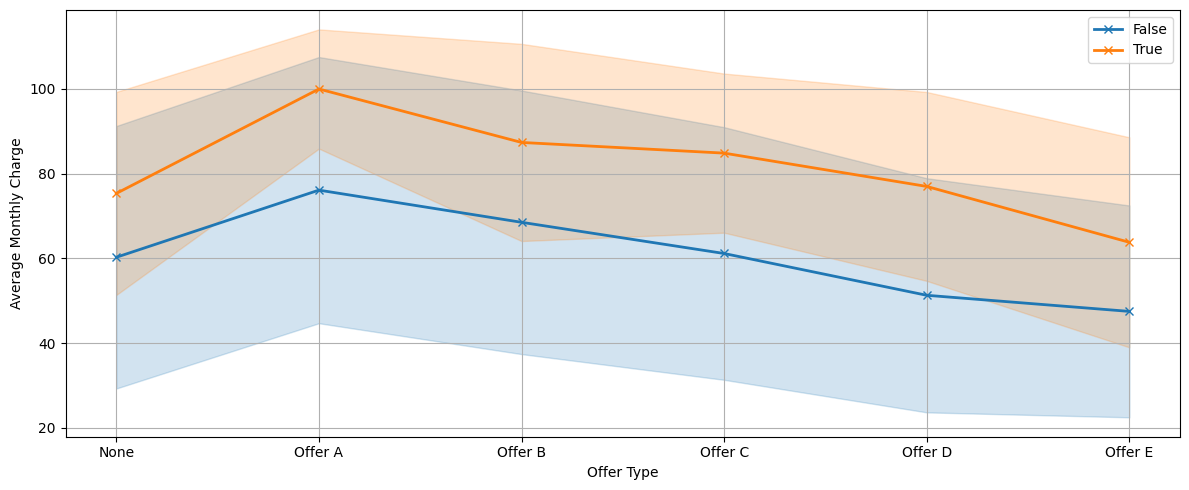

In [16]:
df = churn_count_charge.DataFrame()

fig, ax = plt.subplots(figsize=(12, 5))

for churn_val, group in df.groupby("churn_value"):

    line = ax.plot(group["offer"], group["avg_monthly_charge"], 
                   marker='x', linewidth=2, markersize=6, 
                   label=f"{churn_val}")
    
    color = line[0].get_color()
    
    ax.fill_between(group["offer"], 
                    group["avg_monthly_charge"] - group["montly_charge_sd"],
                    group["avg_monthly_charge"] + group["montly_charge_sd"],
                    alpha=0.2, color=color)

ax.set_xlabel("Offer Type")
ax.set_ylabel("Average Monthly Charge")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

One thing is clear - we are overcharging some of our customers and, in turn, they choosing to go elsewhere.

#### Does the churn rate change with tenure?

In [17]:
%%sql churn_tenure <<
SELECT COUNT(*), churn_value,
CASE
    WHEN months_tenure < 3 THEN '0-3'
    WHEN months_tenure BETWEEN 3 AND 9 THEN '3-9'
    WHEN months_tenure BETWEEN 9 AND 12 THEN '9-12'
    WHEN months_tenure BETWEEN 12 AND 24 THEN '12-24'
    ELSE '24+'
END AS tenure_category
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
GROUP BY tenure_category, churn_value
ORDER BY tenure_category, churn_value

Returning data to local variable churn_tenure


In [18]:
churn_tenure

count,churn_value,tenure_category
348,False,0-3
503,True,0-3
730,False,12-24
294,True,12-24
3295,False,24+
538,True,24+
572,False,3-9
420,True,3-9
229,False,9-12
114,True,9-12


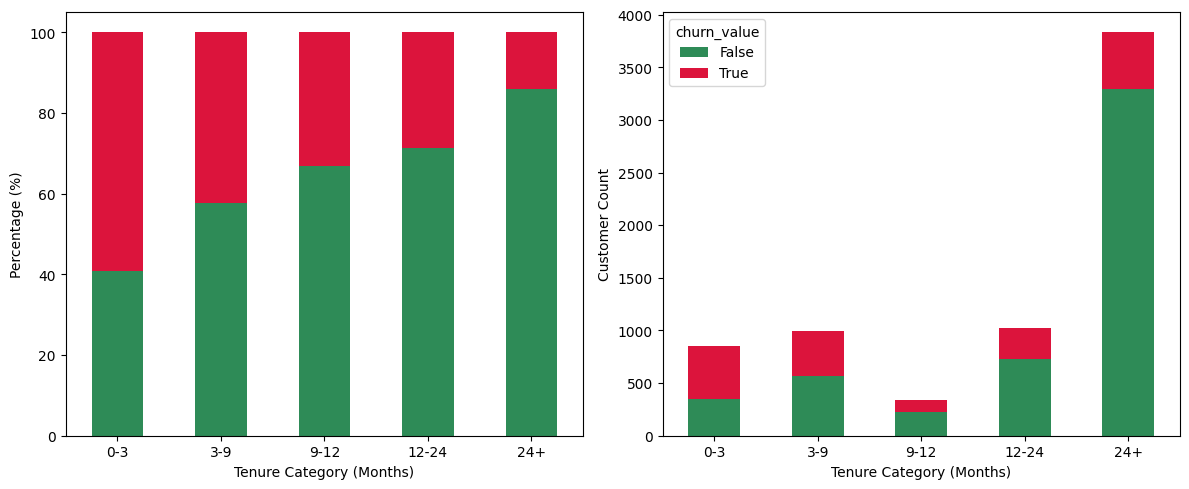

In [19]:
churn_tenure = pd.DataFrame(churn_tenure)

tenure_order = ["0-3", "3-9", "9-12", "12-24", "24+"]

churn_tenure["tenure_category"] = pd.Categorical(churn_tenure["tenure_category"], categories=tenure_order, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
pivot_df_pct = churn_tenure.pivot(index="tenure_category", columns="churn_value", values="count")
pivot_df_pct = pivot_df_pct.reindex(tenure_order)
pivot_df_pct = pivot_df_pct.div(pivot_df_pct.sum(axis=1), axis=0) * 100
pivot_df_pct.plot(kind="bar", stacked=True, ax=ax1, color=["#2E8B57", "#DC143C"])
ax1.set_xlabel("Tenure Category (Months)")
ax1.set_ylabel("Percentage (%)")
ax1.tick_params(axis="x", rotation=0)
ax1.get_legend().remove()

ax2 = axes[1]
pivot_df = churn_tenure.pivot(index="tenure_category", columns="churn_value", values="count")
pivot_df = pivot_df.reindex(tenure_order)
pivot_df.plot(kind="bar", stacked=True, ax=ax2, color=["#2E8B57", "#DC143C"])
ax2.set_xlabel("Tenure Category (Months)")
ax2.set_ylabel("Customer Count")
ax2.tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()

As it turns out, we are loosing the clients that have been with the company the shortest, especially those in the 0 to 3 month tenure range. This could be a sign that special offers should be used to incentivise new clients to stay. It is also possible that our service is not up to standarts and we should improve the services that we offer. It could also be that these new clients were signed up with a promotion and they decided not to say. We should investigate further.